In [1]:
import cartopy.crs as ccrs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pygrib

from pyproj import CRS
from pyproj import Transformer


def create_grb_projection(grb):
    
    # grid definition
    radius = grb.radius
    central_lat = grb.LaDInDegrees
    central_lon = grb.LoVInDegrees
    first_secant_lat = grb.Latin1InDegrees
    second_secant_lat = grb.Latin2InDegrees
    
    # Set up the projection information
    globe = ccrs.Globe(semimajor_axis=radius)
    data_proj = ccrs.LambertConformal(globe=globe, central_latitude=central_lat,
                                      central_longitude=central_lon,
                                      standard_parallels=(first_secant_lat, second_secant_lat))
    return data_proj


def lon_lat_to_grid_coords(lon, lat, data_proj):
    x, y = data_proj.transform_point(lon,
                                     lat,
                                     src_crs=ccrs.PlateCarree())
    return x, y


def grb_to_da(grb):
    
    # data
    values = grb.values[np.newaxis, ...]
    t = np.array(grb.validDate)[..., np.newaxis]
    analysis_date = grb.analDate
    parameter = grb.parameterName
    unit = grb.parameterUnits
    
    # grid definition
    first_grid_point_lon = grb.longitudeOfFirstGridPointInDegrees
    first_grid_point_lat = grb.latitudeOfFirstGridPointInDegrees
    
    nx = grb.Nx
    ny = grb.Ny
    dx = grb.DxInMetres
    dy = grb.DyInMetres
    
    
    # define the cartopy crs for the projection
    data_proj = create_grb_projection(grb)
    
    # Transform the corner point lat/lon to an x/y in the projected coordinates
    x0, y0 = lon_lat_to_grid_coords(first_grid_point_lon, 
                                    first_grid_point_lat,
                                    data_proj)
    
    # Generate the grid x/y from that corner using the number of point and the spacing
    x = x0 + np.arange(nx) * dx
    y = y0 + np.arange(ny) * dy\
    

    # create x array data array
    da = xr.DataArray(data=values,
                  dims=["time", "y", "x"],
                  coords=dict(
                      x=x,
                      y=y,
                      time=t
                      ),
                  attrs=dict(
                      paramter=parameter,
                      unit=unit,
                      analysis_date=analysis_date,
                      crs_wkt=data_proj.to_wkt()
                      )
                 )
    
    return da


def create_forecast_cube(grbs):
    """iterate through grb messages in a grib file, 
        create data arrays for each timestamp, 
        and concatenate them togeher into a 3D data array"""
    arrays = list()

    for grb in grbs:
        da = grb_to_da(grb)
        arrays.append(da)

    forecast_cube = xr.concat(arrays, dim="time")
    return forecast_cube

# https://vlab.noaa.gov/web/mdl/ndfd-grid-data
# https://vlab.noaa.gov/web/mdl/ndfd-grib-all-sections

In [2]:
# download the forecast grib file
!wget 'https://noaa-ndfd-pds.s3.amazonaws.com/opnl/AR.conus/VP.001-003/ds.temp.bin' -O forecast.bin

--2022-03-14 22:08:02--  https://noaa-ndfd-pds.s3.amazonaws.com/opnl/AR.conus/VP.001-003/ds.temp.bin
Resolving noaa-ndfd-pds.s3.amazonaws.com (noaa-ndfd-pds.s3.amazonaws.com)... 54.231.202.169
Connecting to noaa-ndfd-pds.s3.amazonaws.com (noaa-ndfd-pds.s3.amazonaws.com)|54.231.202.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47339364 (45M) [application/octet-stream]
Saving to: ‘forecast.bin’

forecast.bin        100%[===================>]  45.15M  8.44MB/s    in 5.5s    

2022-03-14 22:08:08 (8.25 MB/s) - ‘forecast.bin’ saved [47339364/47339364]



In [3]:
grbs = pygrib.open('forecast.bin')
grbs.seek(0)
for grb in grbs:
    print(grb)

1:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 1 hrs:from 202203150400
2:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 2 hrs:from 202203150400
3:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 3 hrs:from 202203150400
4:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 4 hrs:from 202203150400
5:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 5 hrs:from 202203150400
6:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 6 hrs:from 202203150400
7:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 7 hrs:from 202203150400
8:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 8 hrs:from 202203150400
9:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 9 hrs:from 202203150400
10:2 metre temperature:K (instant):lambert:heightAboveGround:lev

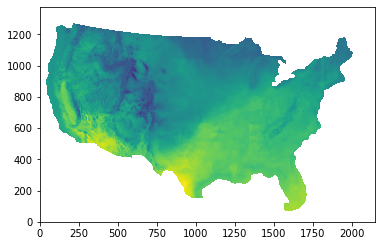

In [4]:
plt.imshow(grb.values, origin='lower')

In [5]:
grbs.seek(0)
forecast_cube = create_forecast_cube(grbs)
forecast_cube

<xarray.DataArray (time: 47, y: 1377, x: 2145)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x        (x) float64 -2.764e+06 -2.762e+06 ... 2.678e+06 2.681e+06
  * y        (y) float64 -2.609e+05 -2.584e+05 ... 3.231e+06 3.234e+06
  * time     (time) datetime64[ns] 2022-03-15T05:00:00 ... 2022-03-18
Attributes:
    paramter:       Temperature
    unit:           K
    analysis_date:  2022-03-15 04:00:00
    crs_wkt:        PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknown",E...

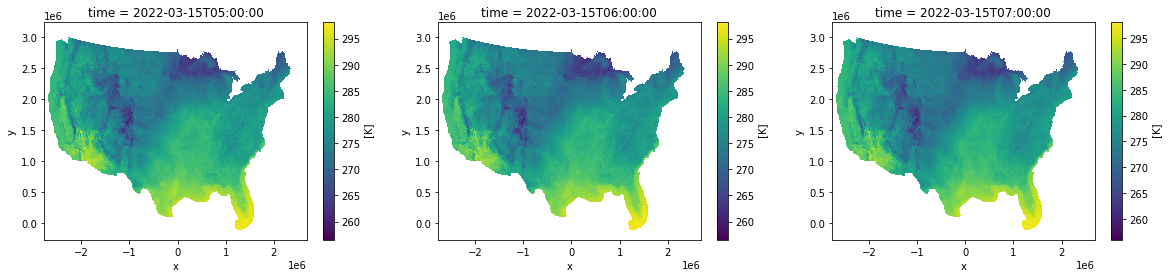

In [6]:
fig, axes = plt.subplots(ncols=3, figsize=(20,4))
for i, ax in enumerate(axes):
    forecast_cube.isel(time=i).plot(ax=ax)

In [7]:
forecast_cube.shape

(47, 1377, 2145)

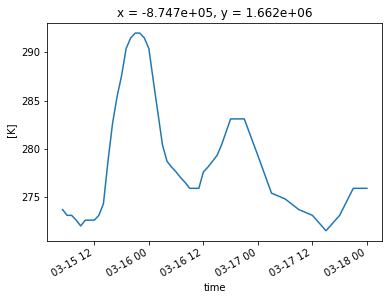

In [8]:
data_crs = CRS.from_wkt(forecast_cube.crs_wkt)
crs_4326 = CRS.from_epsg(4326)

t = Transformer.from_crs(crs_4326, data_crs, always_xy=True)
x, y = t.transform(-104.848, 39.560)
forecast_cube.sel(x=x, y=y, method='nearest').plot()

In [9]:
grb.keys()

['globalDomain',
 'GRIBEditionNumber',
 'tablesVersionLatestOfficial',
 'tablesVersionLatest',
 'grib2divider',
 'angleSubdivisions',
 'missingValue',
 'ieeeFloats',
 'isHindcast',
 'section0Length',
 'identifier',
 'discipline',
 'editionNumber',
 'totalLength',
 'sectionNumber',
 'section1Length',
 'numberOfSection',
 'centre',
 'centreDescription',
 'subCentre',
 'tablesVersion',
 'masterDir',
 'localTablesVersion',
 'significanceOfReferenceTime',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'second',
 'dataDate',
 'julianDay',
 'dataTime',
 'productionStatusOfProcessedData',
 'typeOfProcessedData',
 'md5Section1',
 'selectStepTemplateInterval',
 'selectStepTemplateInstant',
 'stepType',
 'is_chemical',
 'is_chemical_distfn',
 'is_chemical_srcsink',
 'is_aerosol',
 'is_aerosol_optical',
 'setCalendarId',
 'deleteCalendarId',
 'sectionNumber',
 'grib2LocalSectionPresent',
 'deleteLocalDefinition',
 'sectionNumber',
 'gridDescriptionSectionPresent',
 'section3Length',
 'numberOfSec

In [10]:
grb.parameterUnits

'K'

In [11]:
grb.parameterName

'Temperature'

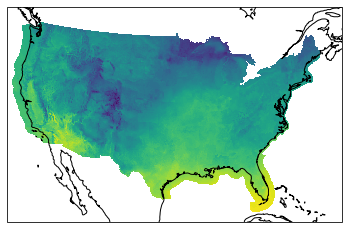

In [12]:
#code from @dopplershift

import matplotlib.pyplot as plt
import pygrib

# Open grib and get the first message
grbs = pygrib.open('forecast.bin')
msg = grbs[1]

# Set up the projection information
globe = ccrs.Globe(semimajor_axis=msg['radius'])
data_proj = ccrs.LambertConformal(globe=globe, central_latitude=msg['LaDInDegrees'],
                                  central_longitude=msg['LoVInDegrees'],
                                  standard_parallels=(msg['Latin1InDegrees'], msg['Latin2InDegrees']))

# Transform the corner point lat/lon to an x/y in the projected coordinates
x0, y0 = data_proj.transform_point(msg['longitudeOfFirstGridPointInDegrees'],
                                   msg['latitudeOfFirstGridPointInDegrees'],
                                   src_crs=ccrs.PlateCarree())

# Generate the grid x/y from that corner using the number of point and the spacing
x = x0 + np.arange(msg['Nx']) * msg['DxInMetres']
y = y0 + np.arange(msg['Ny']) * msg['DyInMetres']

# Plot on a map to verify we got this right
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=data_proj)
ax.pcolormesh(x, y, msg.values)
ax.coastlines()

In [13]:
print('radius of earth:', msg.radius)
print('LaDInDegrees: ', msg.LaDInDegrees)
print('LoVInDegrees: ', msg.LoVInDegrees)
print('Latin1InDegrees', msg.Latin1InDegrees)
print('Latin2InDegrees', msg.Latin2InDegrees)
print('longitudeOfFirstGridPointInDegrees:', msg.longitudeOfFirstGridPointInDegrees)
print('latitudeOfFirstGridPointInDegrees:', msg.latitudeOfFirstGridPointInDegrees)
print('Nx:', msg.Nx)
print('Ny:', msg.Ny)
print('DxInMetres:', msg.DxInMetres)
print('DyInMetres:', msg.DyInMetres)#, msg.LaDInDegrees, msg.LoVInDegrees, msg.radius

radius of earth: 6371200.0
LaDInDegrees:  25.0
LoVInDegrees:  265.0
Latin1InDegrees 25.0
Latin2InDegrees 25.0
longitudeOfFirstGridPointInDegrees: 238.445999
latitudeOfFirstGridPointInDegrees: 20.191999
Nx: 2145
Ny: 1377
DxInMetres: 2539.703
DyInMetres: 2539.703


In [14]:
x, y

(array([-2764251.52997483, -2761711.82697483, -2759172.12397483, ...,
         2675792.29602517,  2678331.99902517,  2680871.70202517]),
 array([-260891.10816169, -258351.40516169, -255811.70216169, ...,
        3228660.81383831, 3231200.51683831, 3233740.21983831]))

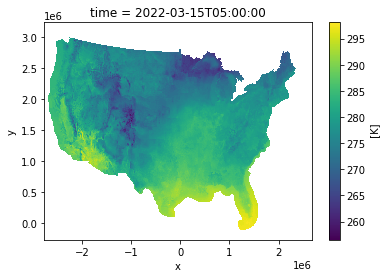

In [15]:
grb = grbs[1]

values = grb.values[np.newaxis, ...]
lat, lon = grb.latlons()
t = np.array(grb.validDate)[..., np.newaxis]
analysis_date = grb.analDate
parameter = grb.parameterName
unit = grb.parameterUnits

da = xr.DataArray(data=values,
              dims=["time", "y", "x"],
              coords=dict(
                  x=x,
                  y=y,
                  time=t
                  ),
              attrs=dict(
                  paramter=parameter,
                  unit=unit,
                  analysis_date=analysis_date)
             )
da.plot()

In [16]:
x, y = data_proj.transform_point(-104.8, 39.5,
                                   src_crs=ccrs.PlateCarree())
x, y

(-870075.4806080422, 1655591.1780763748)

In [17]:
da.sel(x=x, y=y, method='nearest')

<xarray.DataArray (time: 1)>
array([273.1])
Coordinates:
    x        float64 -8.696e+05
    y        float64 1.657e+06
  * time     (time) datetime64[ns] 2022-03-15T05:00:00
Attributes:
    paramter:       Temperature
    unit:           K
    analysis_date:  2022-03-15 04:00:00

In [18]:
import pyproj

In [19]:
from pyproj import CRS
from pyproj import Transformer
data_crs = CRS.from_wkt(forecast_cube.crs_wkt)
crs_4326 = CRS.from_epsg(4326)

t = Transformer.from_crs(crs_4326, data_crs, always_xy=True)
t.transform(-104.848, 39.560)

(-873830.0532781974, 1662764.868873452)